<h2> DQN Agent <h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [3]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.1]
Best error: 0.08599320903375537


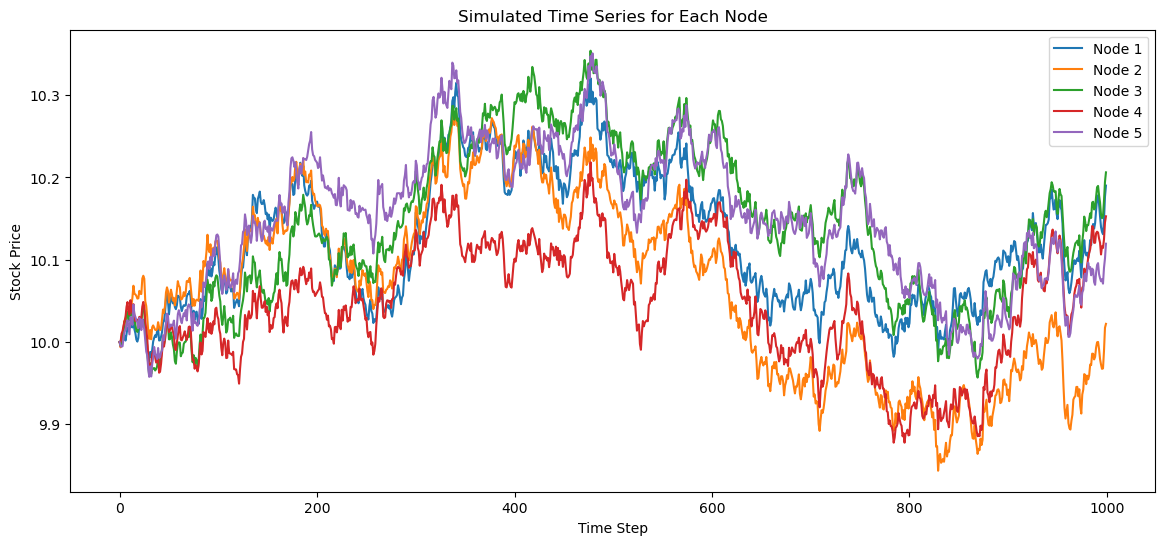

In [4]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

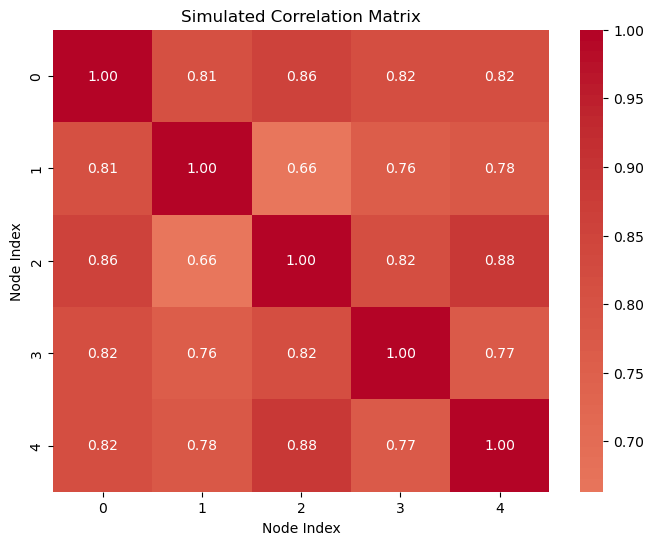

In [6]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [7]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

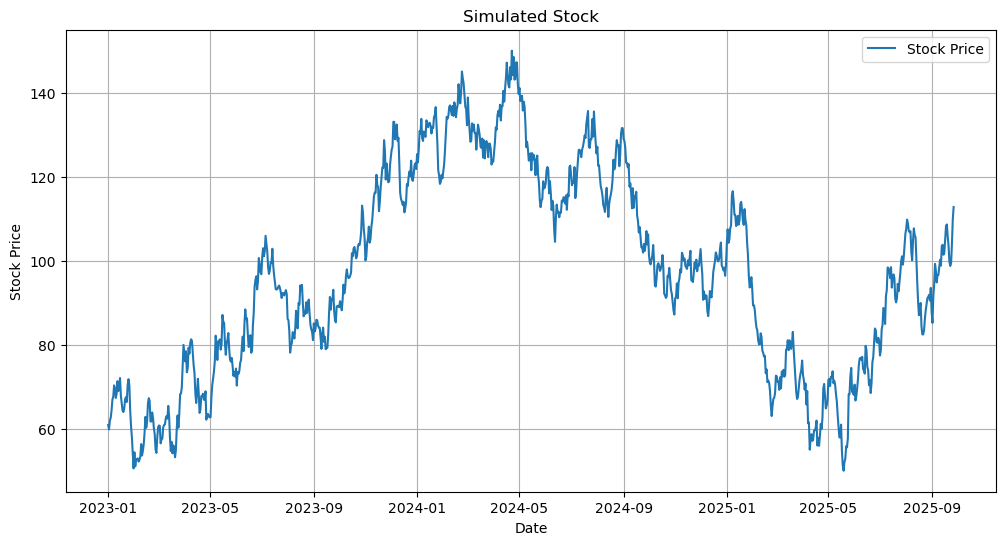

In [8]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [53]:
import numpy as np
import random
from collections import deque

class StockTradingEnvironment:
    def __init__(self, stock_prices, transaction_fee=0.001):
        self.stock_prices = stock_prices
        self.transaction_fee = transaction_fee
        self.current_step = 0
        self.balance = 1000  # Initial balance
        self.shares = 0  # Initial shares held

    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.shares = 0
        print(f"Environment reset. Initial balance: {self.balance}, Shares: {self.shares}")
        return self.get_state(self.current_step)

    def get_state(self, step, window_size=5):
        # Create a state representation (last `window_size` prices)
        start = max(0, step - window_size + 1)
        state = self.stock_prices[start:step + 1]
        state = np.pad(state, (0, window_size - len(state)), 'constant', constant_values=0)
        return state

    def take_action(self, action):
        current_price = self.stock_prices[self.current_step]
        reward = 0

        if action == 0:  # Hold
            if self.current_step > 0 and self.stock_prices[self.current_step] > self.stock_prices[self.current_step - 1]:
                reward = 0.1  # Reward for holding if the price has increased
            else:
                reward = -0.01  # Small penalty for holding
            action_str = "Hold"
        
        elif action == 1:  # Buy
            if self.balance >= current_price:
                self.shares += 1
                self.balance -= current_price * (1 + self.transaction_fee)  # Account for transaction fee
                reward = -0.05  # Small negative reward for buying
                action_str = "Buy"
            else:
                reward = -1  # Not enough balance to buy
                action_str = "Buy (Failed)"
        
        elif action == 2:  # Sell
            if self.shares > 0:
                sale_amount = current_price * (1 - self.transaction_fee)
                self.balance += sale_amount
                profit = sale_amount - current_price  # Profit from selling
                self.shares -= 1
                reward = profit + 0.1  # Positive reward for selling, plus a small bonus
                action_str = "Sell"
            else:
                reward = -1  # No shares to sell
                action_str = "Sell (Failed)"

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.stock_prices) - 1  # End if we reach the last price

        print(f"Step: {self.current_step}, Action: {action_str}, "
              f"Current Price: {current_price:.2f}, "
              f"Balance: {self.balance:.2f}, Shares: {self.shares}, "
              f"Reward: {reward:.2f}")

        return self.get_state(self.current_step), reward, done

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Simple neural network model
        from keras.models import Sequential
        from keras.layers import Dense

        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])  # Exploit

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def load_model(self, name):
        """ Load a saved model """
        self.model.load_weights(name)

    def save_model(self, name):
        """ Save the model weights """
        self.model.save_weights(name)
            

class StockTradingAgent:
    def __init__(self, stock_prices):
        self.env = StockTradingEnvironment(stock_prices)
        self.state_size = 5  # Window size for state representation
        self.action_size = 3  # Hold, Buy, Sell
        self.agent = DQNAgent(self.state_size, self.action_size)

    def train(self, epochs, batch_size=32):
        for e in range(epochs):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])

            for time in range(len(self.env.stock_prices) - 1):
                action = self.agent.choose_action(state)
                next_state, reward, done = self.env.take_action(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.agent.remember(state, action, reward, next_state, done)

                state = next_state

                if done:
                    total_value = self.env.balance + self.env.shares * self.env.stock_prices[self.env.current_step]
                    print(f"Episode: {e + 1}/{epochs}, Total Value: {total_value:.2f}, Epsilon: {self.agent.epsilon:.2}")
                    break

                self.agent.replay(batch_size)

In [54]:
# Initialize and train the multi-agent trading bot with an initial balance of $100,000 per agent
agent = StockTradingAgent(df['StockPrice'])
agent.train(epochs=1, batch_size=32)
# Save the model after training
agent.agent.save_model("dqn_agent.h5")

Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Hold, Current Price: 60.90, Balance: 1000.00, Shares: 0, Reward: -0.01
Step: 2, Action: Hold, Current Price: 59.84, Balance: 1000.00, Shares: 0, Reward: -0.01
Step: 3, Action: Buy, Current Price: 61.93, Balance: 938.01, Shares: 1, Reward: -0.05
Step: 4, Action: Hold, Current Price: 62.61, Balance: 938.01, Shares: 1, Reward: 0.10
Step: 5, Action: Hold, Current Price: 64.36, Balance: 938.01, Shares: 1, Reward: 0.10
Step: 6, Action: Sell, Current Price: 66.93, Balance: 1004.88, Shares: 0, Reward: 0.03
Step: 7, Action: Buy, Current Price: 67.63, Balance: 937.18, Shares: 1, Reward: -0.05
Step: 8, Action: Sell, Current Price: 70.32, Balance: 1007.43, Shares: 0, Reward: 0.03
Step: 9, Action: Hold, Current Price: 69.68, Balance: 1007.43, Shares: 0, Reward: -0.01
Step: 10, Action: Hold, Current Price: 67.33, Balance: 1007.43, Shares: 0, Reward: -0.01
Step: 11, Action: Sell (Failed), Current Price: 68.36, Balance: 1007.43, Shar

/Users/bedabratachoudhury/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Step: 33, Action: Sell, Current Price: 51.03, Balance: 932.63, Shares: 1, Reward: 0.05
Step: 34, Action: Sell, Current Price: 52.61, Balance: 985.18, Shares: 0, Reward: 0.05
Step: 35, Action: Sell (Failed), Current Price: 52.81, Balance: 985.18, Shares: 0, Reward: -1.00
Step: 36, Action: Sell (Failed), Current Price: 52.92, Balance: 985.18, Shares: 0, Reward: -1.00
Step: 37, Action: Hold, Current Price: 52.18, Balance: 985.18, Shares: 0, Reward: -0.01
Step: 38, Action: Sell (Failed), Current Price: 52.61, Balance: 985.18, Shares: 0, Reward: -1.00
Step: 39, Action: Sell (Failed), Current Price: 53.40, Balance: 985.18, Shares: 0, Reward: -1.00
Step: 40, Action: Sell (Failed), Current Price: 56.34, Balance: 985.18, Shares: 0, Reward: -1.00
Step: 41, Action: Sell (Failed), Current Price: 53.63, Balance: 985.18, Shares: 0, Reward: -1.00
Step: 42, Action: Buy, Current Price: 54.73, Balance: 930.40, Shares: 1, Reward: -0.05
Step: 43, Action: Sell, Current Price: 56.29, Balance: 986.64, Shares

Step: 126, Action: Sell (Failed), Current Price: 73.65, Balance: 1001.48, Shares: 0, Reward: -1.00
Step: 127, Action: Sell (Failed), Current Price: 76.10, Balance: 1001.48, Shares: 0, Reward: -1.00
Step: 128, Action: Buy, Current Price: 82.15, Balance: 919.25, Shares: 1, Reward: -0.05
Step: 129, Action: Hold, Current Price: 80.07, Balance: 919.25, Shares: 1, Reward: -0.01
Step: 130, Action: Sell, Current Price: 76.37, Balance: 995.54, Shares: 0, Reward: 0.02
Step: 131, Action: Buy, Current Price: 80.77, Balance: 914.69, Shares: 1, Reward: -0.05
Step: 132, Action: Buy, Current Price: 80.90, Balance: 833.72, Shares: 2, Reward: -0.05
Step: 133, Action: Sell, Current Price: 81.29, Balance: 914.93, Shares: 1, Reward: 0.02
Step: 134, Action: Hold, Current Price: 78.84, Balance: 914.93, Shares: 1, Reward: -0.01
Step: 135, Action: Hold, Current Price: 80.22, Balance: 914.93, Shares: 1, Reward: 0.10
Step: 136, Action: Hold, Current Price: 87.09, Balance: 914.93, Shares: 1, Reward: 0.10
Step: 13

Step: 219, Action: Buy, Current Price: 82.98, Balance: 8.93, Shares: 12, Reward: -0.05
Step: 220, Action: Buy (Failed), Current Price: 82.86, Balance: 8.93, Shares: 12, Reward: -1.00
Step: 221, Action: Sell, Current Price: 81.48, Balance: 90.33, Shares: 11, Reward: 0.02
Step: 222, Action: Sell, Current Price: 83.70, Balance: 173.94, Shares: 10, Reward: 0.02
Step: 223, Action: Hold, Current Price: 88.07, Balance: 173.94, Shares: 10, Reward: 0.10
Step: 224, Action: Sell, Current Price: 84.39, Balance: 258.25, Shares: 9, Reward: 0.02
Step: 225, Action: Hold, Current Price: 83.88, Balance: 258.25, Shares: 9, Reward: -0.01
Step: 226, Action: Sell, Current Price: 89.97, Balance: 348.13, Shares: 8, Reward: 0.01
Step: 227, Action: Hold, Current Price: 89.56, Balance: 348.13, Shares: 8, Reward: -0.01
Step: 228, Action: Sell, Current Price: 94.13, Balance: 442.16, Shares: 7, Reward: 0.01
Step: 229, Action: Hold, Current Price: 93.22, Balance: 442.16, Shares: 7, Reward: -0.01
Step: 230, Action: S

Step: 312, Action: Sell, Current Price: 108.11, Balance: 215.36, Shares: 8, Reward: -0.01
Step: 313, Action: Sell, Current Price: 109.63, Balance: 324.87, Shares: 7, Reward: -0.01
Step: 314, Action: Sell, Current Price: 112.43, Balance: 437.19, Shares: 6, Reward: -0.01
Step: 315, Action: Buy, Current Price: 115.32, Balance: 321.75, Shares: 7, Reward: -0.05
Step: 316, Action: Sell, Current Price: 116.23, Balance: 437.87, Shares: 6, Reward: -0.02
Step: 317, Action: Buy, Current Price: 116.17, Balance: 321.59, Shares: 7, Reward: -0.05
Step: 318, Action: Sell, Current Price: 120.46, Balance: 441.92, Shares: 6, Reward: -0.02
Step: 319, Action: Sell, Current Price: 118.04, Balance: 559.84, Shares: 5, Reward: -0.02
Step: 320, Action: Buy, Current Price: 117.50, Balance: 442.23, Shares: 6, Reward: -0.05
Step: 321, Action: Buy, Current Price: 111.80, Balance: 330.32, Shares: 7, Reward: -0.05
Step: 322, Action: Hold, Current Price: 114.07, Balance: 330.32, Shares: 7, Reward: 0.10
Step: 323, Acti

Step: 403, Action: Sell (Failed), Current Price: 134.50, Balance: 1168.99, Shares: 0, Reward: -1.00
Step: 404, Action: Buy, Current Price: 136.66, Balance: 1032.20, Shares: 1, Reward: -0.05
Step: 405, Action: Hold, Current Price: 137.00, Balance: 1032.20, Shares: 1, Reward: 0.10
Step: 406, Action: Sell, Current Price: 135.80, Balance: 1167.86, Shares: 0, Reward: -0.04
Step: 407, Action: Hold, Current Price: 134.69, Balance: 1167.86, Shares: 0, Reward: -0.01
Step: 408, Action: Sell (Failed), Current Price: 136.86, Balance: 1167.86, Shares: 0, Reward: -1.00
Step: 409, Action: Hold, Current Price: 134.48, Balance: 1167.86, Shares: 0, Reward: -0.01
Step: 410, Action: Sell (Failed), Current Price: 137.71, Balance: 1167.86, Shares: 0, Reward: -1.00
Step: 411, Action: Sell (Failed), Current Price: 136.65, Balance: 1167.86, Shares: 0, Reward: -1.00
Step: 412, Action: Sell (Failed), Current Price: 134.18, Balance: 1167.86, Shares: 0, Reward: -1.00
Step: 413, Action: Buy, Current Price: 136.17, 

Step: 493, Action: Hold, Current Price: 136.73, Balance: 883.20, Shares: 2, Reward: -0.01
Step: 494, Action: Sell, Current Price: 132.67, Balance: 1015.74, Shares: 1, Reward: -0.03
Step: 495, Action: Sell, Current Price: 127.05, Balance: 1142.66, Shares: 0, Reward: -0.03
Step: 496, Action: Buy, Current Price: 128.31, Balance: 1014.22, Shares: 1, Reward: -0.05
Step: 497, Action: Sell, Current Price: 126.51, Balance: 1140.61, Shares: 0, Reward: -0.03
Step: 498, Action: Sell (Failed), Current Price: 123.82, Balance: 1140.61, Shares: 0, Reward: -1.00
Step: 499, Action: Sell (Failed), Current Price: 124.37, Balance: 1140.61, Shares: 0, Reward: -1.00
Step: 500, Action: Sell (Failed), Current Price: 125.56, Balance: 1140.61, Shares: 0, Reward: -1.00
Step: 501, Action: Buy, Current Price: 121.53, Balance: 1018.95, Shares: 1, Reward: -0.05
Step: 502, Action: Hold, Current Price: 125.62, Balance: 1018.95, Shares: 1, Reward: 0.10
Step: 503, Action: Hold, Current Price: 124.12, Balance: 1018.95, S

Step: 584, Action: Hold, Current Price: 116.87, Balance: 884.80, Shares: 2, Reward: -0.01
Step: 585, Action: Buy, Current Price: 115.64, Balance: 769.05, Shares: 3, Reward: -0.05
Step: 586, Action: Sell, Current Price: 113.29, Balance: 882.23, Shares: 2, Reward: -0.01
Step: 587, Action: Sell, Current Price: 112.64, Balance: 994.76, Shares: 1, Reward: -0.01
Step: 588, Action: Sell, Current Price: 111.62, Balance: 1106.26, Shares: 0, Reward: -0.01
Step: 589, Action: Buy, Current Price: 115.30, Balance: 990.85, Shares: 1, Reward: -0.05
Step: 590, Action: Hold, Current Price: 117.35, Balance: 990.85, Shares: 1, Reward: 0.10
Step: 591, Action: Buy, Current Price: 113.54, Balance: 877.20, Shares: 2, Reward: -0.05
Step: 592, Action: Sell, Current Price: 110.42, Balance: 987.50, Shares: 1, Reward: -0.01
Step: 593, Action: Hold, Current Price: 113.61, Balance: 987.50, Shares: 1, Reward: 0.10
Step: 594, Action: Sell, Current Price: 114.90, Balance: 1102.29, Shares: 0, Reward: -0.01
Step: 595, Ac

Step: 676, Action: Hold, Current Price: 95.83, Balance: 397.72, Shares: 5, Reward: 0.10
Step: 677, Action: Buy, Current Price: 97.95, Balance: 299.67, Shares: 6, Reward: -0.05
Step: 678, Action: Hold, Current Price: 97.22, Balance: 299.67, Shares: 6, Reward: -0.01
Step: 679, Action: Hold, Current Price: 101.90, Balance: 299.67, Shares: 6, Reward: 0.10
Step: 680, Action: Hold, Current Price: 101.26, Balance: 299.67, Shares: 6, Reward: -0.01
Step: 681, Action: Hold, Current Price: 100.04, Balance: 299.67, Shares: 6, Reward: -0.01
Step: 682, Action: Buy, Current Price: 100.51, Balance: 199.06, Shares: 7, Reward: -0.05
Step: 683, Action: Hold, Current Price: 98.80, Balance: 199.06, Shares: 7, Reward: -0.01
Step: 684, Action: Hold, Current Price: 98.39, Balance: 199.06, Shares: 7, Reward: -0.01
Step: 685, Action: Hold, Current Price: 98.04, Balance: 199.06, Shares: 7, Reward: -0.01
Step: 686, Action: Hold, Current Price: 100.08, Balance: 199.06, Shares: 7, Reward: 0.10
Step: 687, Action: Ho

Step: 770, Action: Hold, Current Price: 80.14, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 771, Action: Hold, Current Price: 80.07, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 772, Action: Hold, Current Price: 82.71, Balance: 186.93, Shares: 7, Reward: 0.10
Step: 773, Action: Hold, Current Price: 81.88, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 774, Action: Hold, Current Price: 78.57, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 775, Action: Hold, Current Price: 78.03, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 776, Action: Hold, Current Price: 77.18, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 777, Action: Hold, Current Price: 77.37, Balance: 186.93, Shares: 7, Reward: 0.10
Step: 778, Action: Hold, Current Price: 73.22, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 779, Action: Hold, Current Price: 74.12, Balance: 186.93, Shares: 7, Reward: 0.10
Step: 780, Action: Hold, Current Price: 71.07, Balance: 186.93, Shares: 7, Reward: -0.01
Step: 781, Action: Hold,

Step: 864, Action: Hold, Current Price: 60.49, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 865, Action: Hold, Current Price: 57.93, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 866, Action: Hold, Current Price: 57.93, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 867, Action: Hold, Current Price: 60.98, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 868, Action: Hold, Current Price: 54.69, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 869, Action: Hold, Current Price: 51.29, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 870, Action: Hold, Current Price: 50.00, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 871, Action: Hold, Current Price: 52.12, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 872, Action: Hold, Current Price: 52.77, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 873, Action: Hold, Current Price: 55.85, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 874, Action: Hold, Current Price: 55.55, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 875, Action: Hold, C

Step: 958, Action: Hold, Current Price: 90.24, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 959, Action: Hold, Current Price: 87.02, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 960, Action: Hold, Current Price: 88.69, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 961, Action: Hold, Current Price: 89.95, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 962, Action: Hold, Current Price: 84.41, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 963, Action: Hold, Current Price: 82.46, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 964, Action: Hold, Current Price: 82.44, Balance: 241.88, Shares: 6, Reward: -0.01
Step: 965, Action: Hold, Current Price: 83.32, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 966, Action: Hold, Current Price: 86.05, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 967, Action: Hold, Current Price: 88.18, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 968, Action: Hold, Current Price: 89.58, Balance: 241.88, Shares: 6, Reward: 0.10
Step: 969, Action: Hold, Cu

In [55]:
#Try the model on some simulated data

import numpy as np

# Load the trained agent
agent = StockTradingAgent(stock_prices=None)  # We don't need initial stock prices for loading
agent.agent.load_model("dqn_agent.h5")

# New stock price data for testing (example data)
new_stock_prices = np.array([100, 101, 102, 103, 102, 101, 104, 105, 106])  # Replace with your new prices

# Initialize the environment with new stock prices
test_env = StockTradingEnvironment(new_stock_prices, transaction_fee=0.001)

# Reset the environment to get the initial state
state = test_env.reset()
state = np.reshape(state, [1, agent.state_size])  # Reshape for the model input

# Simulate the trading environment using the loaded model
done = False
while not done:
    action = agent.agent.choose_action(state)  # Choose action based on the loaded model
    next_state, reward, done = test_env.take_action(action)  # Take action in the environment
    next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape for the next state
    state = next_state  # Update the state for the next iteration

# After the loop, print the final results
total_value = test_env.balance + test_env.shares * test_env.stock_prices[test_env.current_step]
print(f"Final Total Value: {total_value:.2f}, Final Balance: {test_env.balance:.2f}, Final Shares: {test_env.shares}")

Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Buy, Current Price: 100.00, Balance: 899.90, Shares: 1, Reward: -0.05
Step: 2, Action: Hold, Current Price: 101.00, Balance: 899.90, Shares: 1, Reward: 0.10
Step: 3, Action: Buy, Current Price: 102.00, Balance: 797.80, Shares: 2, Reward: -0.05
Step: 4, Action: Hold, Current Price: 103.00, Balance: 797.80, Shares: 2, Reward: 0.10
Step: 5, Action: Buy, Current Price: 102.00, Balance: 695.70, Shares: 3, Reward: -0.05
Step: 6, Action: Buy, Current Price: 101.00, Balance: 594.60, Shares: 4, Reward: -0.05
Step: 7, Action: Hold, Current Price: 104.00, Balance: 594.60, Shares: 4, Reward: 0.10
Step: 8, Action: Sell, Current Price: 105.00, Balance: 699.49, Shares: 3, Reward: -0.01
Final Total Value: 1017.49, Final Balance: 699.49, Final Shares: 3
